# ASTR596, FDS: Homework set 2 - Maximum Likelihood


## Problem 1

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process. I.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected
- Make a QQ plot of the residuals
- Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties $dy$
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search.
- You know the drill by now - QQ plot of the residuals

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

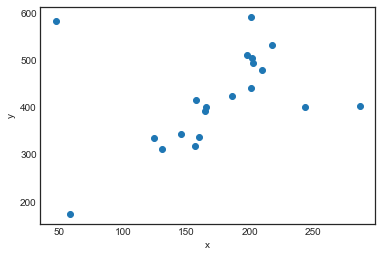

In [153]:
import numpy,math
import scipy.optimize as optimization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
from astroML.datasets import fetch_hogg2010test
from sklearn.metrics import mean_squared_error
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn import linear_model
import scipy.stats as stats
import matplotlib.cm as cm

%matplotlib inline
plt.style.use('seaborn-white')

data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x,y)

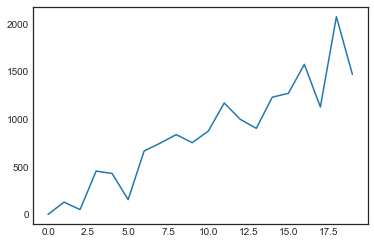

In [176]:
a = np.linspace(0, 10, 20)
b = np.linspace(0, 10, 20)

def y_model(a, b, x, dy):
    y_model = a*x + b + stats.norm.pdf(0, dy)
    return y_model

y_model(a,b,x,dy)
plt.plot(y_model(a,b,x,dy))

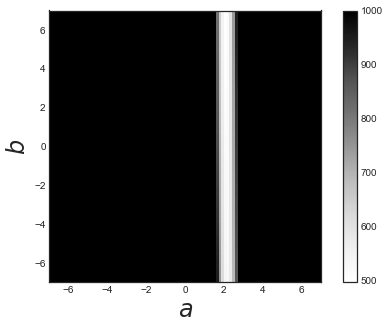

In [254]:
import numpy,math
import scipy.optimize as optimization
import matplotlib.pyplot as plt

# y-model
def y_model(x, a, b, sigma):
    return a*x+b+stats.norm.pdf(0, sigma)  

# our fetch_hogg2010test()
data = fetch_hogg2010test()
xdata = data['x']
ydata = data['y']
sigma = data['sigma_y']

# Compute squared loss/chi^2 manifold.
Steps = 101  # grid size
Chi2Manifold = numpy.zeros([Steps,Steps])  #grid
amin = -7.0  
amax = +7.0 
bmin = -7.0  
bmax = +7.0  
for s1 in range(Steps):
    for s2 in range(Steps):
        a = amin + (amax - amin)*float(s1)/(Steps-1)
        b = bmin + (bmax - bmin)*float(s2)/(Steps-1)
        
        # Evaluate sq loss
        chi2 = 0.0
        for n in range(len(xdata)):
            residual = (ydata[n] - y_model(xdata[n], a, b, sigma[n]))/sigma[n]
            chi2 = chi2 + residual*residual
        Chi2Manifold[Steps-1-s2,s1] = chi2  # write result to grid.
    
    
plt.figure(1, figsize=(8,5))

# Plot squared loss/chi^2 manifold
image = plt.imshow(Chi2Manifold, vmax = 1000, #restricted so i can see where lowest is
                   extent=[amin, amax, bmin, bmax])
plt.colorbar(image) 
plt.xlim(amin, amax)
plt.ylim(bmin, bmax)
plt.xlabel(r'$a$', fontsize=14)
plt.ylabel(r'$b$', fontsize=14)
plt.show()

Looks like a=2, b can be any value in range...

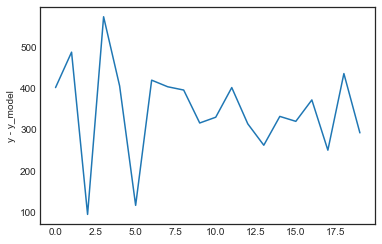

In [227]:
#a=2, b=0

plt.ylabel('y - y_model')
plt.plot(y_model(2,0,x,dy))

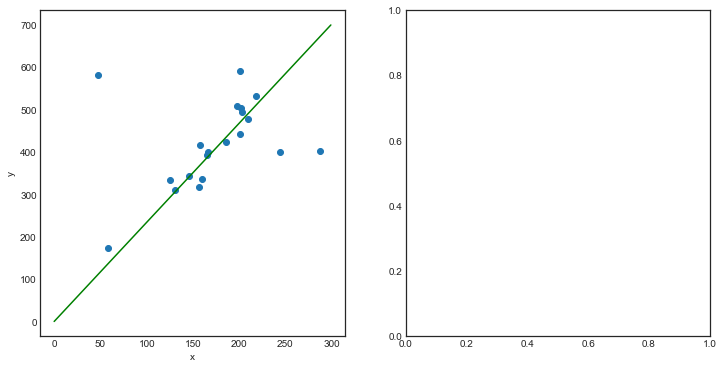

In [237]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

x = data['x']
y = data['y']
marker = np.linspace(0,1000,300)

from scipy.optimize import curve_fit
def f(x, A, B): # this is my 'straight line' y=f(x)
    return A*x + B
popt, pcov = curve_fit(f, x, y) 

fit = .7*marker + 0.16

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.scatter(x,y)
ax1.plot(fit, 'g')

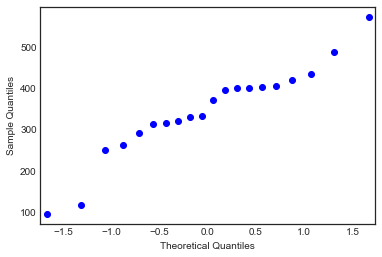

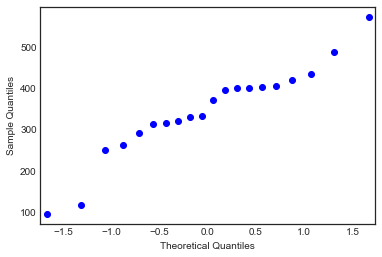

In [265]:
import statsmodels.api as sm
sm.qqplot(y_model(2,0,x,dy)) 

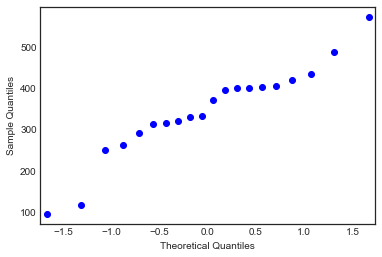

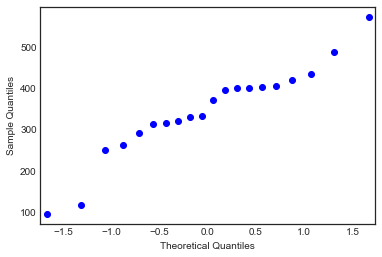

In [269]:
# clipped
clip_y_model = sigma_clip(y_model(2,0,x,dy), sigma=3)
sm.qqplot(clip_y_model)

In [270]:
# huber loss
def huber(true, pred, delta):
    loss = np.where(np.abs(true-pred) < delta , 0.5*((true-pred)**2), delta*np.abs(true - pred) - 0.5*(delta**2))
    return np.sum(loss)

Now do same a,b grid plot for huber loss! If I could get it to work, that's what I would do...

In [271]:
import numpy,math
import scipy.optimize as optimization
import matplotlib.pyplot as plt

# y-model
def y_model(x, a, b, sigma):
    return a*x+b+stats.norm.pdf(0, sigma)  

# our fetch_hogg2010test()
data = fetch_hogg2010test()
xdata = data['x']
ydata = data['y']
sigma = data['sigma_y']

# Compute huber manifold.
Steps = 101  # grid size
Chi2Manifold = numpy.zeros([Steps,Steps])  #grid
amin = -7.0  
amax = +7.0 
bmin = -7.0  
bmax = +7.0  
for s1 in range(Steps):
    for s2 in range(Steps):
        a = amin + (amax - amin)*float(s1)/(Steps-1)
        b = bmin + (bmax - bmin)*float(s2)/(Steps-1)
        
        # Evaluate Huber
        huber = 0.0
        for n in range(len(xdata)):
            huber = huber(ydata[n], y_model(xdata[n], a, b, sigma[n]), sigma[n])
        HuberManifold[Steps-1-s2,s1] = huber  # write result to grid.
    
    
plt.figure(1, figsize=(8,5))

# Plot huber manifold
image = plt.imshow(Chi2Manifold, vmax = 1000, #restricted so i can see where lowest is
                   extent=[amin, amax, bmin, bmax])
plt.colorbar(image) 
plt.xlim(amin, amax)
plt.ylim(bmin, bmax)
plt.xlabel(r'$a$', fontsize=14)
plt.ylabel(r'$b$', fontsize=14)
plt.show()

TypeError: 'float' object is not callable

In [262]:
from scipy import optimize
minimum = optimize.fmin(huber(x,y_model,1), 1)

TypeError: unsupported operand type(s) for -: 'float' and 'function'

Ok, I had a lot of trouble on this problem, but I can make a guess as to what would happen. Initially, the linear fit to the x,y data of hogg would be ok, but after sigma clipping would be far better because you are excising outliers. And in the qq plot, it would show a much more tight linear fit to the scatter.

Because Huber loss is more linear on the wings than squared loss, this would enact an even tighter linear trend in the qqplot, as the fit would be better.

## Example 2: Optimal Photometry

We now turn to examples of applications of ML in astronomy. 

We'll look at two cases: simple photometry and simultaneous fitting of galaxy size and total flux.

Last week, I had you download a bunch of SDSS data files and plot `MAG_PSF` from them?
But what is this quantitiy and where the heck did it come from?

Have a look at one of the example images we saw as an example of astronomical data

In [3]:
### RUN THIS CELL 
! ds9 -scale zscale ../../data/01/wdd7.071117_0328.073_6.sw.fits

## A star and a point spread function

The stars in those images are not point sources, despite being trillions of kilometers from us. This is because as the light from the stars meet travel to meet their fate on our CCD detectors here on Earth, it gets spread out from a perfect point.

The **Point Spread Function** (the "PSF") is comprised of various contributions: from minute misalignments in the optics, to jitter in the tracking, to diffraction from the spider, to diffusion of the electrons as they travel through the silicon in the CCD ("charge diffusion"), to the homogenization of the PSF due to the refraction and diffraction in the atmosphere.  

The dominant effect is the one ***from the atmosphere***.

![PSF Formation](../02/figures/psf-formation.jpg)

In practice, we don't construct the PSF from *ab initio* considerations because it's impractical to track each of these effects separately.

Instead, we measure it by looking at the observed shape of bright, isolated, point sources (i.e., stars). Those observations are noisy, so we fit analytical profiles to estimate the true PSF.

For simplicity, we will use just a single bivariate Gaussian here.

This is our model.



As before, we'll generate some data - but not for 1000s of sources. Just one. It'll be stored in a variable named `image`
You can see the true parameters of the image 

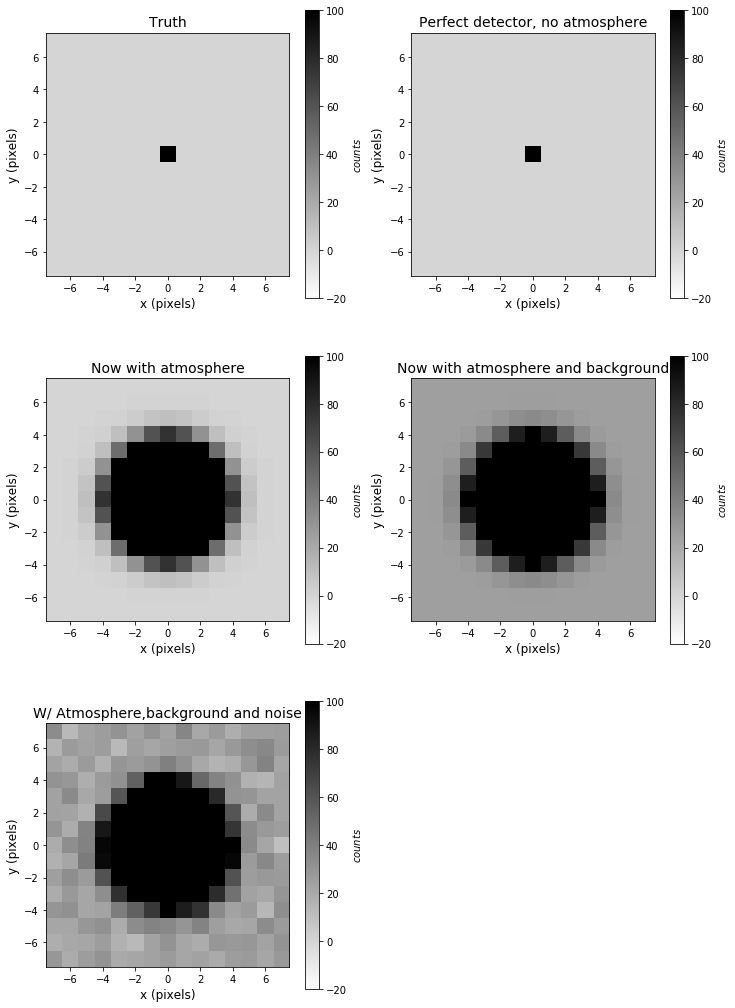

In [4]:
# DO NOT ALTER THIS CODE:
import numpy as np
import math
import matplotlib.pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev
np.random.seed(seed=42)

def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] / 2.

    if title is None:
        title = "min = %.0f, max=%.0f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect=1)
    plt.clim(-20, 100)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)


# These will be the parameters of our image:

Atrue = 10000.0    # the source count normalization
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 25        # sky background


def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./(sigmaPSF**2.)) / (np.sqrt(2.*math.pi)*sigmaPSF)
    return psf

fig = plt.figure(figsize=(12,18))

# uniform flux
image = np.zeros((xdim, ydim))
image[7,7] = Atrue
plotCutout(image, loc=321, fig=fig, title="Truth")

# random Poisson process
image = np.zeros((xdim, ydim))
image[7,7] = np.random.poisson(Atrue)
plotCutout(image, loc=322, fig=fig, title="Perfect detector, no atmosphere")

# PSF 
image = np.zeros((xdim, ydim))
image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
plotCutout(image, loc=323, fig=fig, title="Now with atmosphere")

# PSF with background
image += skyBg
plotCutout(image, loc=324, fig=fig, title="Now with atmosphere and background")

# PSF with background and noise
image = np.random.poisson(image)
plotCutout(image, loc=325, fig=fig, title="W/ Atmosphere,background and noise")

simulatedImage = image

## Photometry (measuring the flux)

We now have an image that we observe, and some ***understanding of the processes that created it***.
We have encoded that understanding into a model.
This means you can now use maximum likelihood to estimate the parameters of the underlying source - like the total area under the profile - a measurement of how much light we received from the source, or it's `FLUX`

The `MAG_PSF` you plotted from the SDSS HLC files last week is directly related to the flux by $-2.5*log_{10}(\text{Flux}) + \text{Constant}$

## PSF Photometry: A Maximum Likelihood estimation of the flux

So our **model** for the image is that it consists of a Gaussian with a flux normalization fo $A$ , plus the background (which we've removed), plus the Gaussian noise (caused by photon quantization).

So, <u>**once the background is removed**</u>, for ***each pixel*** I can write:

>$ I(x,y) = A * PSF(x - x_0, y - y_0) + r_i $

where $A$ is the flux of the star (i.e. the thing we want), and $r_i$ is drawn from a Gaussian with

>$N(0, \sigma_{x,y} = \sqrt{I_{x,y} + B})$

and $B$ is the sky background. It's critical not to forget the background when computing the sigma -- for faint sources, this is where most of the measurement uncertainty comes from!

### For a single pixel 

### $$
\begin{align}
p(I(x_i, y_i)|A, PSF(x_i-x_0, y_i-y_0), \sigma) &= N(I(x_i, y_i) - A*PSF(x_0, y_0)|\sigma) \\
& = \frac{1}{\sqrt{2 \pi \sigma^2}} A\exp \left( - \frac{(I(x_i, y_i) - A*PSF(x_0, y_0))^2}{2 \sigma^2} \right) 
\end{align}
$$

### For a whole image then $p1 \times p2 \times p3$....

### $$ 
\begin{align}
P &= \Gamma p(I(x, y)|A, PSF(x_i-x_0, y_i-y_0), \sigma) \\
& = N(I(x_i, y_i) - A*PSF(x_0, y_0)|\sigma) \\
& = \frac{1}{\sqrt{2 \pi \sigma^2}} A\exp \left( - \frac{(I(x_i, y_i) - A*PSF(x_0, y_0))^2}{2 \sigma^2} \right) 
\end{align}
$$

Note this is practically identical to our case with fitting a line, except that instead of having one index $i$, we have two indices for the data points, $(x, y)$. And ***each pixel*** is an independent data point that constrains our model.

So we can readily write out the log-likelihood as:

### $$\ln{L} = \text{constant} - \sum_{i=1}^N \frac{\left(I(x_i,y_i) - A\  \mathrm{PSF}(x_0,y_0)\right)^2}{2 \sigma^2}$$

As we've seen , maximizing the likelihood of a product of normal distribution reduces to minimizing the $\chi^2$, which is what you'll do next.

## Q2.1 Assume the noise is constant, and minimize the log-likelihood analytically. 
(i.e. some calculus required)

You may wish to define these quantities:

>$\phi_{x,y} = \frac{1}{\sigma^2} \sum_{x,y} I_{x,y}\cdot PSF_{x,y,\sigma_{PSF}}$
                             
>$\psi_{x,y} = \frac{1}{\sigma^2} \sum_{x,y} PSF_{x,y,\sigma_{PSF}}^2$


Looking at the form of $\phi_{x,y}$ and considering it for each pixel **what does it represent?**

## paleo's answer

Looking at the form of $\phi_{x,y}$, this is the convolution of the incident flux with the model PSF for each pixel.
___

We then determine the maximum/minimum. It is the parameter set for which the derivative of $lnL$ is zero:

$$\frac{d\;{\rm lnL}(x,y)}{d (x,y)}\Biggr\rvert_{\hat x,\hat y} \equiv 0.$$

Substitute in $\ln{L} = \text{constant} - \sum_{i=1}^N \frac{\left(I(x_i,y_i) - A\  \mathrm{PSF}(x_0,y_0)\right)^2}{2 \sigma^2}$ to find

$$\sum_{i=1}^N \frac{\left(I(x_i,y_i) - A\  \mathrm{PSF}(x_0,y_0)\right)}{\sigma^2} = 0 $$

This equation is satisfied if the numerator is 0. Thus,

$$\sum_{i=1}^N \left(I(x_i,y_i) - A\  \mathrm{PSF}(x_0,y_0)\right) = 0 $$

$$\sum_{i=1}^N I(x_i,y_i) = A\  \mathrm{PSF}(x_0,y_0) $$

But, $A$ is the measurement we want. So, rearrange to solve for $A$:

$$ A\ = \sum_{i=1}^N \frac{I(x_i,y_i)}{\mathrm{PSF}(x_0,y_0)} $$

If we define the following quantities: 

>$\phi_{x,y} = \frac{1}{\sigma^2} \sum_{x,y} I_{x,y}\cdot PSF_{x,y,\sigma_{PSF}}$
                             
>$\psi_{x,y} = \frac{1}{\sigma^2} \sum_{x,y} PSF_{x,y,\sigma_{PSF}}^2$

then we can rewrite our ratio for $A$ as simply

$$ A\ = \frac{\phi_{x,y}}{\psi_{x,y}} $$.

## Q2.2 Estimating the true flux

To estimate the true flux, we need to maximize the likelihood. That is equivalent to minimizing the $\chi^2$. 

* estimate the background in the image
* estimate the noise in our measurements (remember it's a Poisson process!)
* as with the straight line estimate the true flux grid of A
* Destermine the chi-sq/DoF at each location on the A grid and plot it
* Compare the numerical estimate with your analytical estimate that you made with your answer to Q2.1

Because we know the background in the image, the background will simply be the value of skyBg (that is, 25 counts).

#est_skyBg = image - (Atrue * makePSF(image.shape, 0, 0, sigmaPSF)) - np.random.poisson(image)
#plotCutout(est_skyBg, fig=fig, title="skyBg")

average noise (from Poisson process) across image is 0.7449028097518903 counts


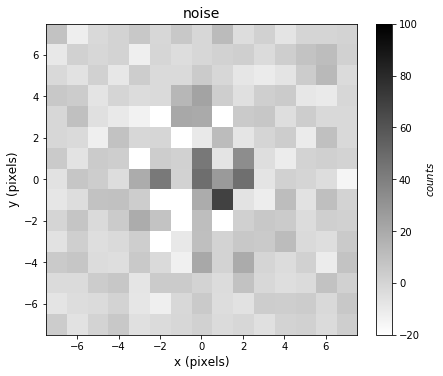

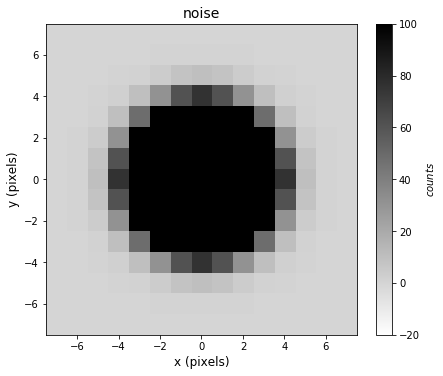

In [5]:
# YOUR CODE GOES HERE

# estimated noise = image (aka final PSF with background and noise) - PSF - background

est_noise = image - (Atrue * makePSF(image.shape, 0, 0, sigmaPSF)) - skyBg
plotCutout(est_noise, fig=fig, title="noise")

plotCutout(Atrue * makePSF(image.shape, 0, 0, sigmaPSF), fig=fig, title="noise")

print('average noise (from Poisson process) across image is', np.average(est_noise), 'counts')

#print(np.average(Atrue * makePSF(image.shape, 0, 0, sigmaPSF)))

estimate of flux grid of A is 44.44444444444444


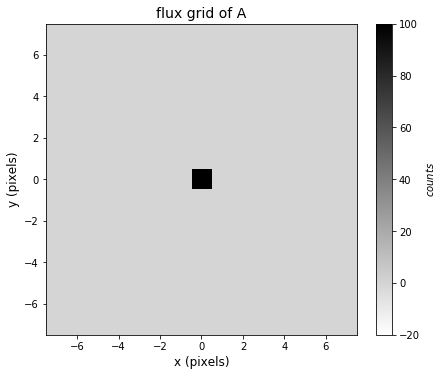

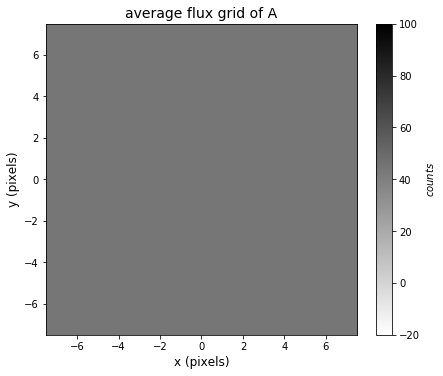

In [6]:
# as with the straight line estimate the true flux grid of A
est_fluxgrid_A = np.zeros((xdim, ydim))
est_fluxgrid_A[7,7] = Atrue
plotCutout(est_fluxgrid_A, fig=fig, title="flux grid of A")

#the straight line estimate the true flux grid of A is the average across the image
print("estimate of flux grid of A is", np.average(est_fluxgrid_A))
#plt.plot(est_fluxgrid_A)

avg_fluxgrid_A = np.zeros((xdim, ydim))
avg_fluxgrid_A += np.average(est_fluxgrid_A)
plotCutout(avg_fluxgrid_A, fig=fig, title="average flux grid of A")
#plt.plot(avg_fluxgrid_A)

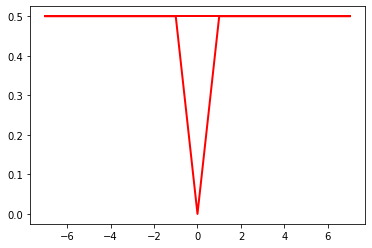

In [7]:
#I DON'T UNDERSTAND CHI-2

import scipy.stats as stats
from scipy.stats import chisquare

chisquare(avg_fluxgrid_A)

xchi = np.arange(-7, 8, 1)
plt.plot(xchi, stats.chi2.pdf(est_fluxgrid_A, df=2), color='r', lw=2)
plt.show()

That^ is bad so ignore...

In [8]:
# analytical estimate A=phi/psi
# numerical estimate is trueA = 10000

phi = np.sum((image * makePSF(image.shape, 0, 0, sigmaPSF)) / sigmaPSF**2)

psi = np.sum((makePSF(image.shape, 0, 0, sigmaPSF)**2) / sigmaPSF**2)

est_A = phi / psi
print("analytical A is :", est_A, "; this is really close to trueA = 10000.")
print("This gives me courage that this is a good model to use")

analytical A is : 10267.953827658406 ; this is really close to trueA = 10000.
This gives me courage that this is a good model to use


## Models with more parameters

The iterative example above is a bit contrived as we can, and did, solve the MLE analytically 

It has the benefit of being general, however. We can apply the same technique to models with more parameters (within the limits of computing power available to us!). The other parameters could be the position of the object ($x$, $y$), or some measure of the shape of the object.

As the number of parameters increases, the likelihood curve from the previous slide becomes the ***likelihood (hyper)surface***. The more dimensions there are, the more difficult (computationally expensive) it becomes to find its maximum using brute force solutions; even for 2D cases, we're likely to resort to ***minimization algorithms*** (e.g., Levenberg–Marquardt or others).

## Q3: Measuring the size and brightness of a spherical, gaussian, galaxy

In Homework 1, you had `MAG_PSF` not just for stars, but also for galaxies. 

Even in the ideal (space) case, the Galaxy will not be a point source. We'll imagine we're dealing with a "Gaussian spherical galaxy" -- i.e., one whose intensity  falls of as a 2D gaussian would. As with the star, we'll asume the position of the galaxy is known.

Our model has two parameters: the measure of the extendedness of the galaxy -- $\sigma$ -- and its total flux, $C$:

>$ I(x, y) = \frac{C}{2 \pi \sigma^2} \exp \left( -\frac{(x-x_0)^2 + (y-y_0)^2}{2\sigma^2} \right) $

We will now have to explore the likelihood surface in $(C, \sigma)$ space, and find the point of its maximum.

Note #2: When generating the simulated image, $I(x, y)$ needs to be ***convolved*** with the PSF. Fortunately (actually, because I'm lazy) we've chosen the galaxy profile to be gaussian, and the convolution of two gaussians with variances $\sigma_1^2$ and $\sigma_2^2$ is also a gaussian with the variance $\sigma_1^2 + \sigma_2^2$ (i.e., it's wider). 

Our function `gauss2D` utilizes this fact to generate the convolved image of the galaxy.

* we will generate two cases with `gauss2D` below:
* using this image as your data evaluate the log-likelihood
    * in Q2, we only did this for the flux $A$
    * now you have two parameters $C$ and it's shape $\sigma$
    * evaluate the likelihood on this grid 
    
    `C = np.linspace(500, 1500, 101)`
    
    `Sigma = np.linspace(0, 2.5, 101)`
    
* plot the noiseless image and the PSF image, returned by `simulate`, `image` itself, and the difference between image and PSF image (also returned by simulate), and your estimated log-likehood surface

In [62]:
def gauss2D(muX, muY, sig, A, skyBg, sigPSF, Xpixels, Ypixels):
    """
    Generate an image of size (Xpixels, Ypixels) with
    a 2D circular Gaussian of total flux A
    with standard deviation sigma^2=sig^2 + sigPSF^2
    superimposed on a uniform background B and centered
    on (muX, muY).
    """
    r = np.sqrt((Xpixels-muX)**2 + (Ypixels-muY)**2)
    # make and set image to the background value
    image = np.empty(r.shape)
    image.fill(skyBg)

    ## now add circular gaussian profile (normalized to A)
    # source gauss convolved with single-gauss PSF  
    sigConvSquare = sig**2 + sigPSF**2
    image += A*np.exp(-r**2/2/sigConvSquare) / (2*math.pi*sigConvSquare)
    return image


def addnoise(inimage, sigNoise, sourceImage, addsourcenoise=0): 
    """Add gaussian noise to the image, and return the image and variance plane"""
    image = np.copy(inimage)
    image += np.random.normal(0, sigNoise, image.shape)
    variance = 0*image + sigNoise**2

    if (addsourcenoise):
        gain = 1.0  # as a reminder...
        sourceVariance = sourceImage/gain
        image += np.random.normal(0, np.sqrt(sourceVariance), image.shape)
        variance += sourceVariance

    return image, variance 


def simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise):
    # set seed
    np.random.seed(42)
    
    # define the (square) grid
    xpix = np.linspace(-7, 7, 15)

    ## make psf (sigtrue=0) 
    psf = gauss2D(muXtrue, muYtrue, 0, Atrue, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)

    ## make noiseless image (convolved with psf given by sigmaPSF, image size given by 1Dpixels) 
    nonoise = gauss2D(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)
 
    ## now add noise
    image, variance = addnoise(nonoise, sigmaNoise, 0) 

    ## difference object - psf
    diffimage = image - psf

    return nonoise, psf, image, diffimage


# Case 1 - a sanity check - if sigtrue (i.e. the shape of the galaxy) is 0 we're back to dealing with a single star.

In [63]:
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigtrue = 0.0     # the intrinsic gaussian source width, sigma (in pixels) 
Atrue = 1000.0    # the source count normalization
skyBg = 25        # sky background
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
sigmaNoise = 5.0  # gaussian sigma for white noise (counts), e.g. due to sky 


nonoise, psf, image, diffimage = simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise)

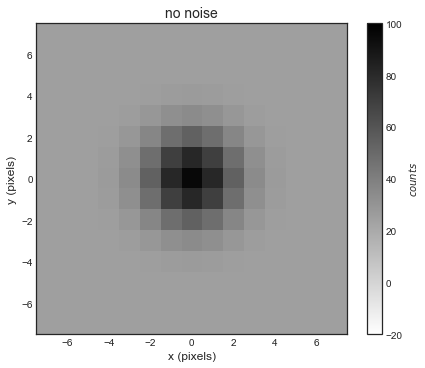

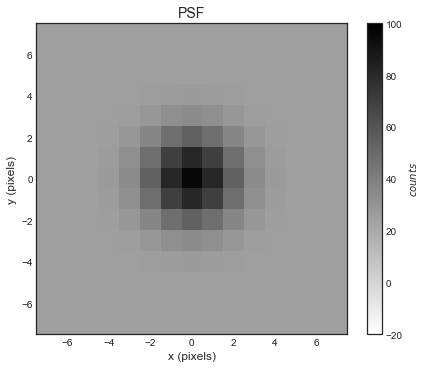

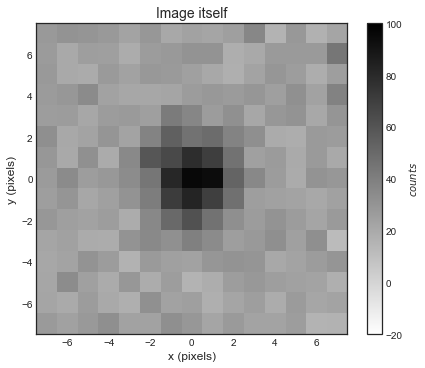

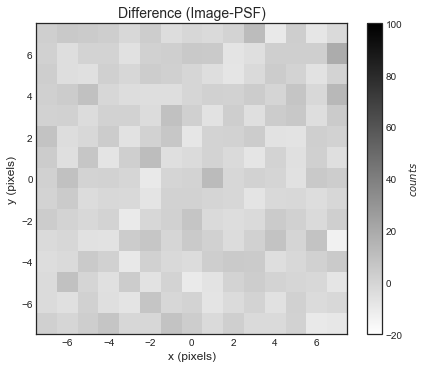

In [64]:
# YOUR CODE TO SOLVE THE HOMEWORK GOES HERE - TRY TO MAKE A FUNCTION YOU CAN REUSE FOR CASE 2

def makePlots(plot1, plot2, plot3, plot4):
    plotCutout(plot1, fig=fig, title="no noise")
    plotCutout(plot2, fig=fig, title="PSF")
    plotCutout(plot3, fig=fig, title="Image itself")
    plotCutout(plot4, fig=fig, title="Difference (Image-PSF)")
    
makePlots(nonoise, psf, image, diffimage)

There is no difference between the object and the PSF. Because the PSF was modeled with *sigtrue=0*, and for our sanity check this object also has *sigtrue=0* (i.e. a star), we can see that indeed if sigtrue (i.e. the shape of the galaxy) is 0 we're back to dealing with a single star! 

>$ I(x, y) = \frac{C}{2 \pi \sigma^2} \exp \left( -\frac{(x-x_0)^2 + (y-y_0)^2}{2\sigma^2} \right) $

> $\ln{L} = \text{constant} - \sum_{i=1}^N \frac{\left(I(x_i,y_i) - A\  \mathrm{PSF}(x_0,y_0)\right)^2}{2 \sigma^2}$

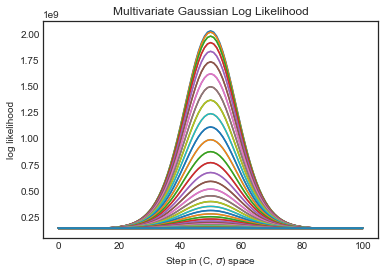

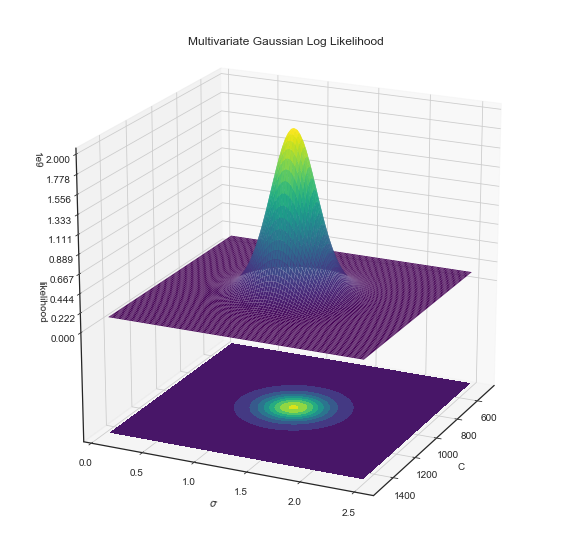

In [192]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn import linear_model

%matplotlib inline
plt.style.use('seaborn-white')

#params
muX = 0
muY = 0
muXtrue = 0
muYtrue = 0
C = np.linspace(500, 1500, 101) #our "X"
sig = np.linspace(0.1, 2.5, 101) #our "Y"
Atrue = 1000
skyBg = 25        
sigmaPSF = 1.5    
sigmaNoise = 5.0  
Xpixels = np.linspace(-7, 7, 101)
Ypixels = np.linspace(-7, 7, 101)
sigtrue = 0
sigConvSquare = sigtrue**2 + sigmaPSF**2

#2D plot version
I = gauss2D(muX, muY, sig, C, skyBg, sigmaPSF, Xpixels, Ypixels) 
psf = gauss2D(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, Xpixels[:, np.newaxis], Ypixels)
logL_2D = (I - (Atrue * psf))**2/ (2*sigConvSquare)

plt.xlabel('Step in (C, $\sigma$) space')
plt.ylabel('log likelihood')
plt.title('Multivariate Gaussian Log Likelihood')
plt.plot(logL_2D)

#Computing the likelihood function I above for each C, sig combination
#logL_3D = np.array(  [np.log(gauss2D(muX, muY, sig, C, skyBg, sigmaPSF, Xpixels, Ypixels))
#                     for xx, yy in zip(np.ravel(C), np.ravel(sig)) ] )

logL_3D = np.array( [logL_2D for xx, yy in zip(np.ravel(C), np.ravel(sig)) ] )

C, sig = np.meshgrid(C, sig) #reshape to get 2-d array

#Plot the result in 3D
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(C, sig, logL_2D, rstride=1, cstride=1, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(C, sig, logL_2D, zdir='z', offset=-1.2e9, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zticks(np.linspace(0,2e9,10))
ax.view_init(20, 25)
ax.set_zlim(-1.2e9,2e9)
ax.set_xlabel('C')
ax.set_ylabel(r'$\sigma$')
ax.set_zlabel('likelihood')
ax.set_title('Multivariate Gaussian Log Likelihood')

plt.show()

# Case 2 - if sigtrue is non-zero, we're dealing with a spherical cow galaxy

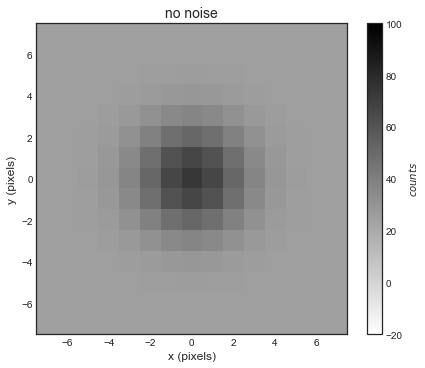

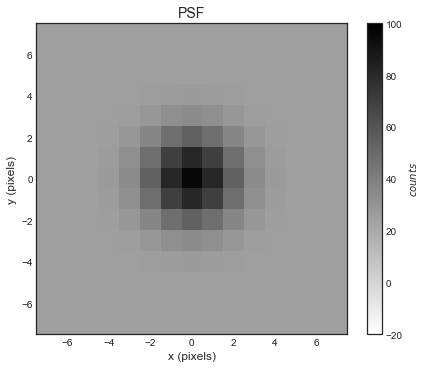

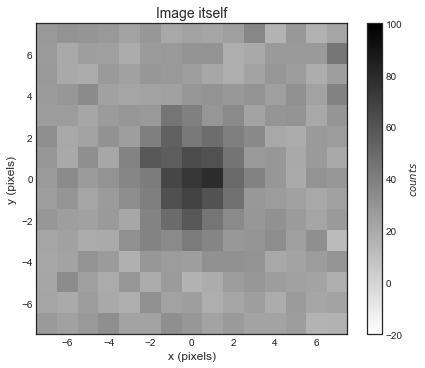

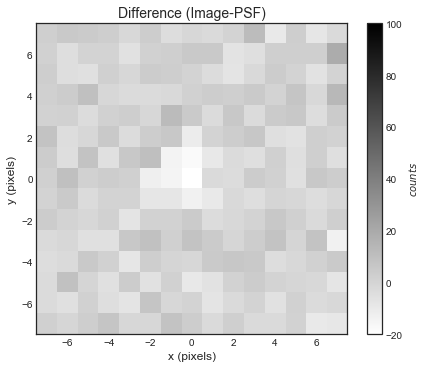

In [85]:
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigtrue = 1.0     # the intrinsic gaussian source width, sigma (in pixels) 
Atrue = 1000.0    # the source count normalization
skyBg = 25        # sky background
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
sigmaNoise = 5.0  # gaussian sigma for white noise (counts), e.g. due to sky 

nonoise, psf, image, diffimage = simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise)

# IF YOU WROTE A SENSIBLE FUNCTION FOR THE STAR CASE, YOU CAN JUST REUSE IT HERE!

def makePlots(plot1, plot2, plot3, plot4):
    plotCutout(plot1, fig=fig, title="no noise")
    plotCutout(plot2, fig=fig, title="PSF")
    plotCutout(plot3, fig=fig, title="Image itself")
    plotCutout(plot4, fig=fig, title="Difference (Image-PSF)")
    
makePlots(nonoise, psf, image, diffimage)

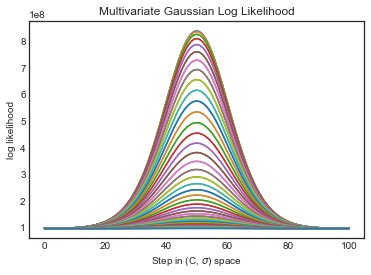

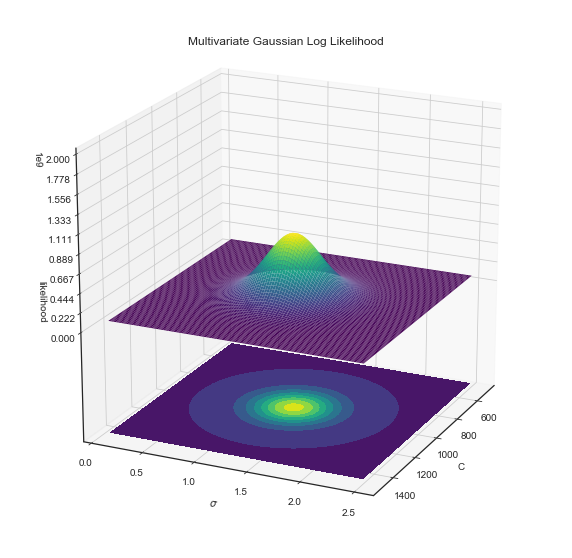

In [193]:
#params
muX = 0
muY = 0
muXtrue = 0
muYtrue = 0
C = np.linspace(500, 1500, 101) #our "X"
sig = np.linspace(0.1, 2.5, 101) #our "Y"
Atrue = 1000
skyBg = 25        
sigmaPSF = 1.5    
sigmaNoise = 5.0  
Xpixels = np.linspace(-7, 7, 101)
Ypixels = np.linspace(-7, 7, 101)
sigtrue = 1 # make this 1 !!!
sigConvSquare = sigtrue**2 + sigmaPSF**2

#2D plot version
I = gauss2D(muX, muY, sig, C, skyBg, sigmaPSF, Xpixels, Ypixels) 
psf = gauss2D(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, Xpixels[:, np.newaxis], Ypixels)
logL_2D = (I - (Atrue * psf))**2/ (2*sigConvSquare)

plt.xlabel('Step in (C, $\sigma$) space')
plt.ylabel('log likelihood')
plt.title('Multivariate Gaussian Log Likelihood')
plt.plot(logL_2D)

#Computing the likelihood function I above for each C, sig combination
#logL_3D = np.array(  [np.log(gauss2D(muX, muY, sig, C, skyBg, sigmaPSF, Xpixels, Ypixels))
#                     for xx, yy in zip(np.ravel(C), np.ravel(sig)) ] )

logL_3D = np.array( [logL_2D for xx, yy in zip(np.ravel(C), np.ravel(sig)) ] )

C, sig = np.meshgrid(C, sig) #reshape to get 2-d array

#Plot the result in 3D
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(C, sig, logL_2D, rstride=1, cstride=1, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(C, sig, logL_2D, zdir='z', offset=-1.2e9, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zticks(np.linspace(0,2e9,10)) #same scale as previous
ax.view_init(20, 25)
ax.set_zlim(-1.2e9,2e9)
ax.set_xlabel('C')
ax.set_ylabel(r'$\sigma$')
ax.set_zlabel('likelihood')
ax.set_title('Multivariate Gaussian Log Likelihood')

plt.show()

**There is a difference** between the object and the PSF. Because the PSF was modeled with *sigtrue=0*, and this object also has *sigtrue=1* (i.e. a spherical galaxy), we can see that the object and PSF are different, and so their difference imaging (that is, image of object - PSF) is non-zero, than we are dealing with two different objects. Our spherical cow galaxy is more spread out and fainter than the PSF, so in the difference imaging we get areas where the PSF is brighter, and so in the subtraction these pixels are of lower counts, and in our likelihood surface. We can see the log likelihood surface of a star, which is a singular point source, and one of a large, spread out spherical galaxy. The likelihood of the galaxy is lower than that of the star by ~factor of 2.